In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "GRF"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn028471,MGPENGVSYEILQSPEATKPKSNIGSGFWKQVRSGSGEEDLRGSKV...,543,1
1,Achn034531,MDLGGLVGPDNGVSSQAISDPETTKPNSNGSGFLKQGRSGSGQDDW...,518,1
2,Achn046551,MVAAEGEGIRSSSSPFTGSQWQELEHQALIFKYLMAGIPVPPHLLL...,280,1
3,Achn116941,MVDQLTEPLILTLDIQWVELEHQALIYKYIVANVPVPSNLLIALKN...,452,1
4,Achn125631,MDLGMVGLDGLLYPSLSSDPEAKQRWYGSGFLKQERPKEEASEDDL...,538,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
619,0.000000,0.001776,0.003552,0.005329,0.003552,0.005329,0.000000,0.000000,0.001776,0.010657,...,0.001776,0.000000,0.000000,0.000000,0.001776,0.000000,0.0,0.0,0.0,0.000000
155,0.000000,0.000000,0.002545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005089,...,0.000000,0.007634,0.002545,0.000000,0.002545,0.002545,0.0,0.0,0.0,0.000000
916,0.005391,0.000000,0.002695,0.000000,0.005391,0.000000,0.002695,0.000000,0.000000,0.002695,...,0.002695,0.002695,0.000000,0.002695,0.008086,0.000000,0.0,0.0,0.0,0.002695
2680,0.006211,0.006211,0.000000,0.006211,0.012422,0.006211,0.000000,0.012422,0.006211,0.006211,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1732,0.001795,0.001795,0.005386,0.001795,0.005386,0.003591,0.001795,0.001795,0.001795,0.003591,...,0.001795,0.000000,0.001795,0.000000,0.000000,0.001795,0.0,0.0,0.0,0.001795


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2980, 441)
X_test: (746, 441)
y_train: (2980,)
y_test: (746,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step - accuracy: 0.5156 - loss: 0.6932

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6645 - loss: 0.6787   

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6835 - loss: 0.6721 - val_accuracy: 0.9715 - val_loss: 0.3780


Epoch 2/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.3770

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9641 - loss: 0.2367

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9648 - loss: 0.2294 - val_accuracy: 0.9849 - val_loss: 0.0425


Epoch 3/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0201

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0433

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0437 - val_accuracy: 0.9866 - val_loss: 0.0374


Epoch 4/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0172

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0350

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0332 - val_accuracy: 0.9883 - val_loss: 0.0312


Epoch 5/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0267

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0182

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0180 - val_accuracy: 0.9883 - val_loss: 0.0278


Epoch 6/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0090

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0130

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0129 - val_accuracy: 0.9883 - val_loss: 0.0335


Epoch 7/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0041

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0115

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0113 - val_accuracy: 0.9983 - val_loss: 0.0110


Epoch 8/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.7357e-04

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0042    

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0048 - val_accuracy: 0.9983 - val_loss: 0.0055


Epoch 9/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0084

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0085 - val_accuracy: 0.9866 - val_loss: 0.0351


Epoch 10/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0048

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0040

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0043 - val_accuracy: 0.9933 - val_loss: 0.0132


Epoch 11/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0071

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0058

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0058 - val_accuracy: 0.9933 - val_loss: 0.0191


Epoch 12/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0013

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 0.9916 - val_loss: 0.0260


Epoch 13/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0019

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0019

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9899 - val_loss: 0.0267


Epoch 14/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4192e-04

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0018    

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9933 - val_loss: 0.0162


Epoch 15/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4924e-04

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0021    

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0020 - val_accuracy: 0.9933 - val_loss: 0.0175


Epoch 16/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.2974e-04

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.0358e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.9699e-04 - val_accuracy: 0.9983 - val_loss: 0.0090


Epoch 17/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9356e-04

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.2804e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.4840e-04 - val_accuracy: 0.9899 - val_loss: 0.0285



[Train Accuracy: 100.00% - Test Accuracy: 99.60%]


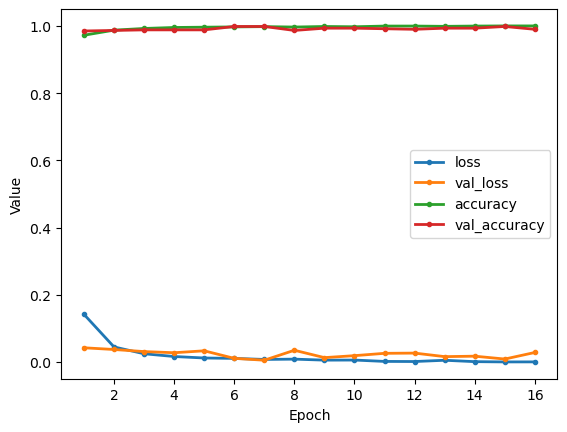

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
619,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
916,0.002703,0.00000,0.002703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002703,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2680,0.000000,0.00625,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1732,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.001799,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2980, 8631)
X_test: (746, 8631)
y_train: (2980,)
y_test: (746,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,209,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,253,057 (8.59 MB)

 Trainable params: 2,253,057 (8.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 17s 473ms/step - accuracy: 0.5625 - loss: 0.6932

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5499 - loss: 0.6923   

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5453 - loss: 0.6906

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5800 - loss: 0.6862

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6192 - loss: 0.6768

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6270 - loss: 0.6741 - val_accuracy: 0.9983 - val_loss: 0.3446


Epoch 2/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9844 - loss: 0.3284

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9856 - loss: 0.2878 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9888 - loss: 0.2411

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9905 - loss: 0.2056

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9916 - loss: 0.1796

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9917 - loss: 0.1749 - val_accuracy: 1.0000 - val_loss: 0.0031


Epoch 3/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0019

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0040 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0036

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0033

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0037

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0010


Epoch 4/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0019

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0022 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0020

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0018

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0017

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 6.7812e-04


Epoch 5/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 7.0643e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.2145e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8767e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5755e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2599e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2101e-04 - val_accuracy: 1.0000 - val_loss: 4.8380e-04


Epoch 6/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.2053e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8306e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1470e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2399e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2381e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2394e-04 - val_accuracy: 1.0000 - val_loss: 3.0789e-04


Epoch 7/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.7363e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8957e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8479e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7729e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7605e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7639e-04 - val_accuracy: 1.0000 - val_loss: 2.7761e-04


Epoch 8/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.5641e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2775e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1381e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0542e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9622e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9420e-04 - val_accuracy: 1.0000 - val_loss: 1.9294e-04


Epoch 9/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.4863e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5460e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7249e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8487e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8769e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8754e-04 - val_accuracy: 1.0000 - val_loss: 1.8625e-04


Epoch 10/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 8.6079e-05

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4608e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5294e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5690e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5574e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5510e-04 - val_accuracy: 1.0000 - val_loss: 1.2980e-04


Epoch 11/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.5481e-05

10/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0083e-04 

19/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0203e-05

28/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1149e-05

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.3095e-05

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 9.3272e-05 - val_accuracy: 1.0000 - val_loss: 1.0576e-04


Epoch 12/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 6.7079e-05

 9/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1959e-05 

18/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5594e-05

27/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6977e-05

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.9955e-05

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0109e-05 - val_accuracy: 1.0000 - val_loss: 9.2465e-05



[Train Accuracy: 100.00% - Test Accuracy: 99.73%]


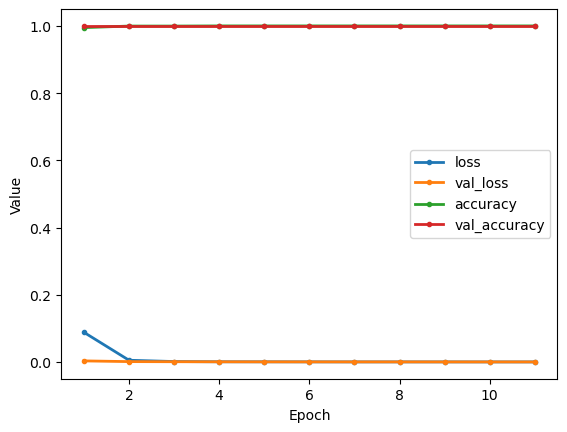

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
619,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
916,0.0,0.0,0.00271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2680,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1732,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      34,301,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,343,169 (131.01 MB)

 Trainable params: 34,343,169 (131.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 24s 668ms/step - accuracy: 0.4062 - loss: 0.6932

 2/38 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.4453 - loss: 0.6930 

 3/38 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.4566 - loss: 0.6930

 4/38 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.4674 - loss: 0.6930

 5/38 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.4727 - loss: 0.6929

 6/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.4768 - loss: 0.6929

 7/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.4782 - loss: 0.6929

 8/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.4792 - loss: 0.6929

 9/38 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.4804 - loss: 0.6929

10/38 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.4820 - loss: 0.6928

11/38 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.4826 - loss: 0.6927

12/38 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4830 - loss: 0.6927

13/38 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4833 - loss: 0.6926

14/38 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.4834 - loss: 0.6925

15/38 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4834 - loss: 0.6924

16/38 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4836 - loss: 0.6923

17/38 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4842 - loss: 0.6921

18/38 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4850 - loss: 0.6920

19/38 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.4862 - loss: 0.6918

20/38 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.4878 - loss: 0.6916

21/38 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4895 - loss: 0.6914

22/38 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4912 - loss: 0.6911

23/38 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4929 - loss: 0.6909

24/38 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4949 - loss: 0.6906

25/38 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4972 - loss: 0.6903

26/38 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4998 - loss: 0.6900

27/38 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5026 - loss: 0.6896

28/38 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5057 - loss: 0.6892

29/38 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5091 - loss: 0.6888

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5126 - loss: 0.6884

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5161 - loss: 0.6879

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5197 - loss: 0.6874

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5233 - loss: 0.6868

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5269 - loss: 0.6862

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5306 - loss: 0.6855

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5343 - loss: 0.6848

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5380 - loss: 0.6841

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5415 - loss: 0.6834

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.5449 - loss: 0.6827 - val_accuracy: 1.0000 - val_loss: 0.5174


Epoch 2/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.5053

 2/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 0.4967

 3/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.4933

 4/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9990 - loss: 0.4922

 5/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9986 - loss: 0.4902

 6/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9984 - loss: 0.4865

 7/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9977 - loss: 0.4828

 8/38 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9972 - loss: 0.4794

 9/38 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9970 - loss: 0.4755

10/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9968 - loss: 0.4718

11/38 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9967 - loss: 0.4680

12/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9966 - loss: 0.4645

13/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9966 - loss: 0.4610

14/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9966 - loss: 0.4575

15/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9966 - loss: 0.4539

16/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9967 - loss: 0.4502

17/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9967 - loss: 0.4463

18/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9967 - loss: 0.4425

19/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9968 - loss: 0.4387

20/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9968 - loss: 0.4348

21/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9969 - loss: 0.4308

22/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9969 - loss: 0.4267

23/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9970 - loss: 0.4227

24/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9970 - loss: 0.4187

25/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9971 - loss: 0.4148

26/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9971 - loss: 0.4108

27/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9971 - loss: 0.4069

28/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9972 - loss: 0.4030

29/38 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9972 - loss: 0.3992

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9973 - loss: 0.3953

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9973 - loss: 0.3915

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9973 - loss: 0.3877

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9974 - loss: 0.3840

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9974 - loss: 0.3803

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9974 - loss: 0.3767

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9975 - loss: 0.3731

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9975 - loss: 0.3695

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9975 - loss: 0.3661

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9975 - loss: 0.3629 - val_accuracy: 0.9983 - val_loss: 0.0342


Epoch 3/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0225

 2/38 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 0.0238

 3/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0235

 4/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 0.0230

 5/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 0.0225

 6/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 0.0220

 7/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 0.0214

 8/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0209

 9/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0204

10/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0199

11/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0194

12/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0190

13/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0186

14/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0182

15/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0178

16/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9999 - loss: 0.0176

17/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9999 - loss: 0.0174

18/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9998 - loss: 0.0171

19/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9998 - loss: 0.0169

20/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9998 - loss: 0.0167

21/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9998 - loss: 0.0164

22/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9997 - loss: 0.0162

23/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9997 - loss: 0.0160

24/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9997 - loss: 0.0158

25/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9997 - loss: 0.0156

26/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9997 - loss: 0.0154

27/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.9997 - loss: 0.0152

28/38 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9997 - loss: 0.0150

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9996 - loss: 0.0148

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9996 - loss: 0.0147

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9996 - loss: 0.0145

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9996 - loss: 0.0143

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9996 - loss: 0.0142

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9995 - loss: 0.0140

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9995 - loss: 0.0139

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9995 - loss: 0.0138

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9995 - loss: 0.0136

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9995 - loss: 0.0135

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9995 - loss: 0.0134 - val_accuracy: 0.9983 - val_loss: 0.0076


Epoch 4/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0026

 2/38 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 0.0026

 3/38 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 1.0000 - loss: 0.0025

 4/38 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 1.0000 - loss: 0.0023

 5/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 0.0022

 6/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 0.0021

 7/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 0.0021

 8/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 0.0021

 9/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 0.0020

10/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 0.0020

11/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 0.0020

12/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 0.0019

13/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 0.0019

14/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 0.0019

15/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0019

16/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0019

17/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0019

18/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0019

19/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 0.0018

20/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0018

21/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0018

22/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0018

23/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0018

24/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0018

25/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0018

26/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0018

27/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0017

28/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0017

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0017

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0017

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0017

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0017

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0017

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0017

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0017

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0017

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 0.0016

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 0.0016

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9983 - val_loss: 0.0074


Epoch 5/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 7.3130e-04

 2/38 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 6.5602e-04

 3/38 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 6.1126e-04

 4/38 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 5.9030e-04

 5/38 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.7700e-04

 6/38 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.6564e-04

 7/38 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 5.5318e-04

 8/38 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 5.4951e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 5.4859e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.5138e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.5357e-04

12/38 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 5.5588e-04

13/38 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 5.5704e-04

14/38 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.5745e-04

15/38 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 5.5729e-04

16/38 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.5690e-04

17/38 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.5617e-04

18/38 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 5.5551e-04

19/38 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.5432e-04

20/38 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.5454e-04

21/38 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 5.5555e-04

22/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 5.5591e-04

23/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 5.5779e-04

24/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 5.5917e-04

25/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 5.6308e-04

26/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 5.6648e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 5.6904e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 5.7150e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 5.7358e-04

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 5.7519e-04

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.7664e-04

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.7762e-04

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.7832e-04

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.7865e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.7883e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.8055e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.8187e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.8307e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 5.8421e-04 - val_accuracy: 0.9983 - val_loss: 0.0068


Epoch 6/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.8371e-04

 2/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 2.6845e-04

 3/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 2.7827e-04

 4/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 2.8441e-04

 5/38 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 2.9002e-04

 6/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 2.9001e-04

 7/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 2.9339e-04

 8/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 2.9428e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 2.9534e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 2.9633e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.9703e-04

12/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 2.9815e-04

13/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 2.9852e-04

14/38 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.9869e-04

15/38 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 2.9875e-04

16/38 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 2.9834e-04

17/38 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 2.9804e-04

18/38 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 2.9975e-04

19/38 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 3.0082e-04

20/38 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 3.0154e-04

21/38 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 3.0213e-04

22/38 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 3.0266e-04

23/38 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 3.0296e-04

24/38 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 3.0298e-04

25/38 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 3.0293e-04

26/38 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 3.0259e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 3.0210e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 3.0160e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 3.0102e-04

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 3.0032e-04

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 3.0007e-04

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.9972e-04

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.9937e-04

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 3.0118e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0291e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0446e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0591e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 3.0727e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 3.0856e-04 - val_accuracy: 0.9983 - val_loss: 0.0060


Epoch 7/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.0122e-04

 2/38 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 2.4874e-04

 3/38 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.7073e-04

 4/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 2.8263e-04

 5/38 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.9341e-04

 6/38 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.9762e-04

 7/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 3.0040e-04

 8/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 2.9985e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 3.0650e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 3.1018e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 3.1267e-04

12/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 3.1545e-04

13/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 3.1730e-04

14/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 3.1873e-04

15/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 3.1921e-04

16/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 3.1938e-04

17/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 3.1886e-04

18/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 3.1938e-04

19/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 3.1950e-04

20/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 3.1947e-04

21/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 3.1916e-04

22/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 3.1852e-04

23/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 3.1767e-04

24/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 3.1660e-04

25/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 3.1554e-04

26/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 3.1436e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 3.1299e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 3.1170e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 3.1027e-04

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 3.0875e-04

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 3.0738e-04

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 3.0614e-04

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 3.0476e-04

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 3.0332e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 3.0183e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 3.0034e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.9883e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 2.9745e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.9613e-04 - val_accuracy: 0.9950 - val_loss: 0.0073


Epoch 8/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.1447e-04

 2/38 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.3507e-04

 3/38 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.3957e-04

 4/38 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.4054e-04

 5/38 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.3978e-04

 6/38 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.3807e-04

 7/38 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.3737e-04

 8/38 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.3583e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.3724e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.3887e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.4028e-04

12/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.4135e-04

13/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.4193e-04

14/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.4204e-04

15/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.4235e-04

16/38 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 1.0000 - loss: 1.4245e-04

17/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.4262e-04

18/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.4272e-04

19/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.4260e-04

20/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.4252e-04

21/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.4233e-04

22/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.4210e-04

23/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.4226e-04

24/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.4239e-04

25/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.4248e-04

26/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.4251e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 1.4246e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 1.4463e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 1.4655e-04

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 1.4822e-04

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 1.4976e-04

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 1.5110e-04

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 1.5236e-04

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 1.5350e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 1.5448e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 1.5562e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 1.5672e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.5775e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.5872e-04 - val_accuracy: 0.9983 - val_loss: 0.0049


Epoch 9/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 7.0135e-05

 2/38 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.5995e-05

 3/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 8.0925e-05

 4/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 9.0311e-05

 5/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 9.5915e-05

 6/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 9.9114e-05

 7/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.0220e-04

 8/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.0419e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.0502e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.0559e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.0641e-04

12/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.0682e-04

13/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.0728e-04

14/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.0796e-04

15/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.0859e-04

16/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.0886e-04

17/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.0914e-04

18/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.0945e-04

19/38 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 1.0966e-04

20/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.0976e-04

21/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.0979e-04

22/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.0977e-04

23/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.0970e-04

24/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.0982e-04

25/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.0994e-04

26/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 1.0998e-04

27/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.1086e-04

28/38 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 1.1165e-04

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.1241e-04

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.1306e-04

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.1357e-04

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.1398e-04

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.1431e-04

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.1461e-04

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.1486e-04

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.1506e-04

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.1519e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.1532e-04

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.1545e-04 - val_accuracy: 0.9983 - val_loss: 0.0053


Epoch 10/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 8.7000e-05

 2/38 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 1.0000 - loss: 9.9706e-05

 3/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.0038e-04

 4/38 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 1.0000 - loss: 1.0680e-04

 5/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.0839e-04

 6/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 1.0836e-04

 7/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 1.0740e-04

 8/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.0599e-04

 9/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 1.0427e-04

10/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 1.0276e-04

11/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 1.0135e-04

12/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 1.0077e-04

13/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 1.0031e-04

14/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 9.9793e-05

15/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 9.9629e-05

16/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 9.9337e-05

17/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 9.9090e-05

18/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 9.8899e-05

19/38 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 9.8671e-05

20/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 9.8566e-05

21/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 9.8485e-05

22/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 9.8281e-05

23/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 9.8070e-05

24/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 9.7919e-05

25/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 9.7740e-05

26/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 9.7491e-05

27/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 9.7256e-05

28/38 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 9.7075e-05

29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.6876e-05

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.6632e-05

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.6386e-05

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.6115e-05

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.5931e-05

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.5726e-05

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.5504e-05

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.5254e-05

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 1.0000 - loss: 9.4974e-05

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 9.4711e-05

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 9.4461e-05 - val_accuracy: 0.9950 - val_loss: 0.0080


Epoch 11/100


 1/38 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.5247e-05

 2/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 4.3443e-05

 3/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 4.8476e-05

 4/38 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 5.3502e-05

 5/38 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 5.5077e-05

 6/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 5.5526e-05

 7/38 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 1.0000 - loss: 5.5672e-05

 8/38 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 5.5696e-05

 9/38 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 5.5492e-05

10/38 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.5356e-05

11/38 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 5.5206e-05

12/38 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.5192e-05

13/38 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.5579e-05

14/38 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 5.5772e-05

15/38 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.5817e-05

16/38 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.5980e-05

17/38 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 5.6096e-05

18/38 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.6136e-05

19/38 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 5.6100e-05

20/38 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 5.6048e-05

21/38 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 5.5972e-05

22/38 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 5.5963e-05

23/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 5.5977e-05

24/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 5.5961e-05

25/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 5.5977e-05

26/38 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 5.5980e-05

27/38 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 5.6086e-05

28/38 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 5.6174e-05

29/38 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 5.6317e-05

30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.6539e-05

31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.6794e-05

32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.7069e-05

33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.7320e-05

34/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.7530e-05

35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.7698e-05

36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.7831e-05

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.7934e-05

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 5.8029e-05

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 5.8119e-05 - val_accuracy: 0.9950 - val_loss: 0.0086



[Train Accuracy: 100.00% - Test Accuracy: 99.73%]


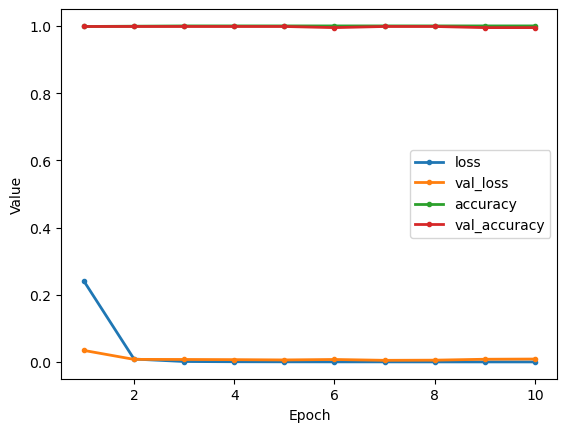

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

 7/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/24 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

 7/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

13/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [25]:
report.save()

Report saved as Output/Reports/GRF/report_UVMP3VCM.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################